# **Surface Crack Prediction**
This notebook focuses on  building an image classification model to automatically detect cracks in concrete surfaces using a dataset of images. The dataset contains two classes: `Positive` (images with cracks) and `Negative` (images without cracks). In this assignment we will:
1.  **Preprocessing:** Preparing the dataset by splitting, normalizing, and organizing images for training, validation, and testing.
2.  **Model Construction:** Constructing a Convolutional Neural Network (CNN) to classify the images effectively.
3.  **Performance Evaluation:** Evaluating the model's accuracy and analyzing its performance using key metrics.
4.  **Bonus Task:**  Enhancing the dataset using augmentation techniques to improve the model's robustness and generalization.

## **Step 1: Preprocess the Images**
### **1.1: Download the dataset**
We begin with retrieving the dataset from Kaggle and verify its structure. Using the `kagglehub` library, we ensure that the dataset is properly downloaded and organized. This step is crucial as all subsequent tasks depend on a clean and structured dataset. The dataset consists of two folders: `Positive` and `Negative`, each containing 20,000 images.

In [2]:
import kagglehub

# Download latest version dataset version using kagglehub
path = kagglehub.dataset_download("arunrk7/surface-crack-detection")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/surface-crack-detection


### **1.2: Organize the dataset**
To facilitate model training and evaluation, we split the dataset into training (70%), validation (15%), and test (15%) sets. Each split ensures the dataset has a balanced number of images for both classes.

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define source folders
negative_dir = os.path.join(path, "Negative")
positive_dir = os.path.join(path, "Positive")

# Define target folders
base_dir = "crack_data"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Create directories
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)
    os.makedirs(os.path.join(directory, "Positive"), exist_ok=True)
    os.makedirs(os.path.join(directory, "Negative"), exist_ok=True)

# Function to split data
def split_data(source, train, val, test):
    files = os.listdir(source)
    train_files, test_files = train_test_split(files, test_size=0.3, random_state=42)
    val_files, test_files = train_test_split(test_files, test_size=0.5, random_state=42)

    for f in train_files:
        shutil.copy(os.path.join(source, f), os.path.join(train, f))
    for f in val_files:
        shutil.copy(os.path.join(source, f), os.path.join(val, f))
    for f in test_files:
        shutil.copy(os.path.join(source, f), os.path.join(test, f))

# Split for both classes
split_data(negative_dir, os.path.join(train_dir, "Negative"), os.path.join(val_dir, "Negative"), os.path.join(test_dir, "Negative"))
split_data(positive_dir, os.path.join(train_dir, "Positive"), os.path.join(val_dir, "Positive"), os.path.join(test_dir, "Positive"))


### **1.3: Normalize the images**
Normalizing pixel values to the range [0, 1] helps improve model training by standardizing the input values, ensuring consistency and stability during gradient updates.

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image preprocessing and augmentation

# Normalize pixel values using rescaling
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(227, 227), batch_size=32, class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    val_dir, target_size=(227, 227), batch_size=32, class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    test_dir, target_size=(227, 227), batch_size=32, class_mode='binary'
)


Found 28000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


## **Step 2: Construct and Train a Convolutional Neural Network**
### **2.1: Define the CNN architecture**
 The CNN is designed to extract spatial features (using convolutional layers) and classify images (using dense layers). Dropout is used to prevent overfitting.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(227, 227, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### **2.2: Compile the model**
The model is compiled using the Adam optimizer, which adapts the learning rate during training. Binary cross-entropy is the appropriate loss function for binary classification, and we also monitor accuracy, precision, and recall.

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow import keras

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
    ]
)

### **2.3: Train the model**
The model is trained for 20 epochs on the training set and evaluated on the validation set after each epoch. This helps track performance and adjust parameters as needed.

In [7]:
history = model.fit(train_generator, validation_data=val_generator, epochs=20)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


875/875 ━━━━━━━━━━━━━━━━━━━━ 70s 71ms/step - accuracy: 0.7449 - loss: 0.5172 - precision: 0.7615 - recall: 0.7123 - val_accuracy: 0.9567 - val_loss: 0.1270 - val_precision: 0.9797 - val_recall: 0.9327
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 55s 63ms/step - accuracy: 0.9640 - loss: 0.1242 - precision: 0.9794 - recall: 0.9483 - val_accuracy: 0.9707 - val_loss: 0.0837 - val_precision: 0.9876 - val_recall: 0.9533
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 58s 66ms/step - accuracy: 0.9728 - loss: 0.1003 - precision: 0.9844 - recall: 0.9602 - val_accuracy: 0.9773 - val_loss: 0.0677 - val_precision: 0.9848 - val_recall: 0.9697
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 55s 62ms/step - accuracy: 0.9771 - loss: 0.0821 - precision: 0.9862 - recall: 0.9683 - val_accuracy: 0.9765 - val_loss: 0.0614 - val_precision: 0.9904 - val_recall: 0.9623
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 57s 65ms/step - accuracy: 0.9814 - loss: 0.0675 - precision: 0.9892 - recall: 0.9735 - val_accuracy: 0.9803 - val_loss: 0.0

## **Step 3: Calculate Performance Measures and Analyze Results**
### **3.1: Evaluate the model on the test set**
We evaluate the trained model on the unseen test set to measure its ability to generalize to new data. Metrics such as accuracy, precision, recall, and loss are reported.

In [8]:
# Evaluate model and get all metrics
test_loss, test_acc, test_precision, test_recall = model.evaluate(
    test_generator)

# Print formatted results
print(f"\nTest Metrics:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"Loss: {test_loss:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9965 - loss: 0.0148 - precision: 0.9969 - recall: 0.9961

Test Metrics:
Accuracy: 0.9955
Precision: 0.9957
Recall: 0.9953
Loss: 0.0169


### **3.2: Visualize training performance**
Visualizing loss, accuracy, precision, and recall across epochs helps understand whether the model is overfitting or underfitting. It also gives insights into training stability.

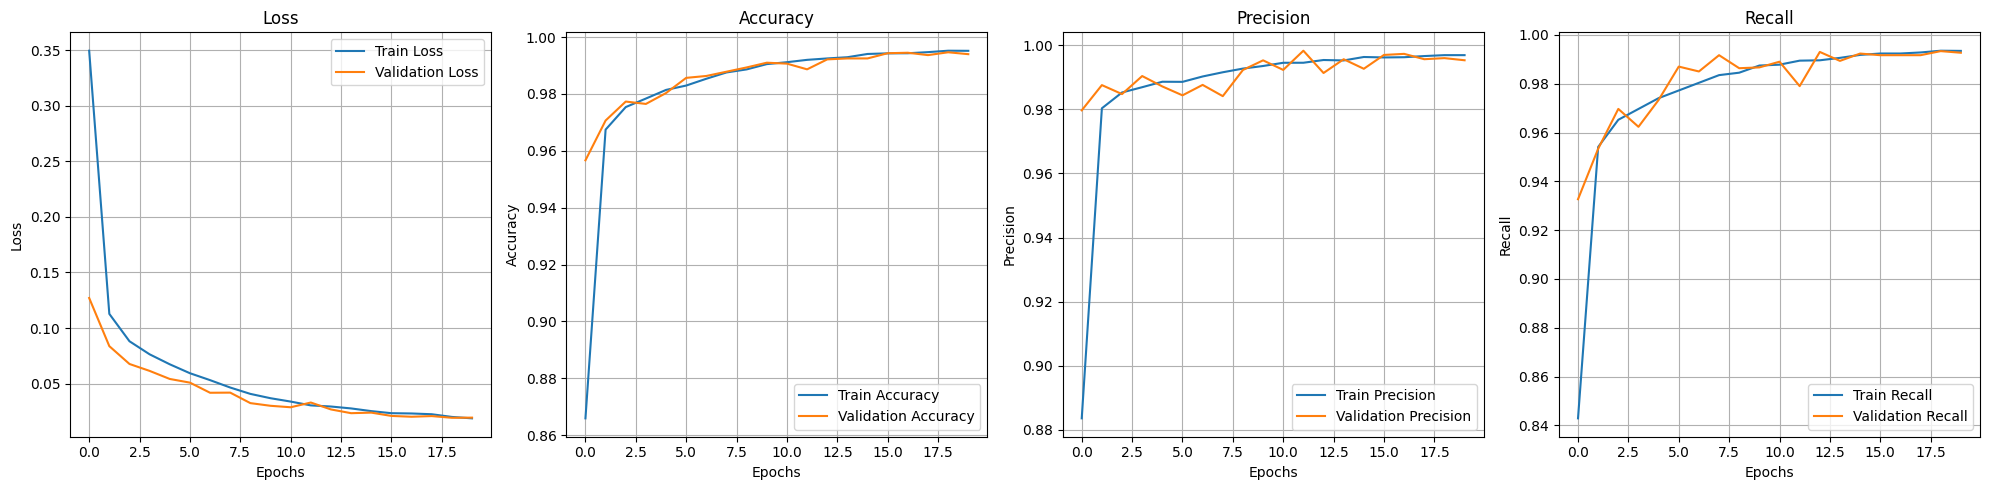

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))

metrics = ['loss', 'accuracy', 'precision', 'recall']
titles = ['Loss', 'Accuracy', 'Precision', 'Recall']

for i, metric in enumerate(metrics):
    plt.subplot(1, 4, i+1)
    plt.plot(history.history[metric], label=f'Train {titles[i]}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {titles[i]}')
    plt.title(titles[i])
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## **Step 4 (Bonus Task): Use Data Augmentation to Enhance Performance**
### **4.1: Augment the Data**
To improve generalization and reduce overfitting, we use data augmentation techniques such as rotation, translation, and zoom. This artificially increases the training data variability.

In [10]:
import tensorflow as tf
model_aug = tf.keras.models.clone_model(model)
model_aug.set_weights(model.get_weights())


In [11]:
model_aug.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


In [12]:
aug_train_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
)

aug_train_data = aug_train_gen.flow_from_directory(
    train_dir, target_size=(227, 227), batch_size=32, class_mode='binary')

Found 28000 images belonging to 2 classes.


### **4.2: Retrain with Augmented Data**
We retrain the model using the augmented dataset, applying early stopping to avoid overfitting. This approach helps the model learn more robust features and perform better on unseen data.

In [13]:
import tensorflow as tf
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=3, restore_best_weights=True)
# Train with augmentation
history_aug = model_aug.fit(
    aug_train_data,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop]
)

Epoch 1/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 333s 377ms/step - accuracy: 0.9918 - loss: 0.0311 - precision: 0.9946 - recall: 0.9888 - val_accuracy: 0.9928 - val_loss: 0.0239 - val_precision: 0.9894 - val_recall: 0.9963
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 340s 389ms/step - accuracy: 0.9920 - loss: 0.0296 - precision: 0.9945 - recall: 0.9898 - val_accuracy: 0.9948 - val_loss: 0.0208 - val_precision: 0.9943 - val_recall: 0.9953
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 331s 378ms/step - accuracy: 0.9930 - loss: 0.0262 - precision: 0.9949 - recall: 0.9910 - val_accuracy: 0.9947 - val_loss: 0.0180 - val_precision: 0.9970 - val_recall: 0.9923
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 326s 373ms/step - accuracy: 0.9937 - loss: 0.0249 - precision: 0.9964 - recall: 0.9910 - val_accuracy: 0.9937 - val_loss: 0.0226 - val_precision: 0.9897 - val_recall: 0.9977
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 331s 378ms/step - accuracy: 0.9919 - loss: 0.0255 - precision: 0.9948 - recall: 0.9889 - val_accuracy: 0

In [14]:
# Evaluate on TEST set
test_metrics = model_aug.evaluate(test_generator)
test_loss = test_metrics[0]
test_accuracy = test_metrics[1]
test_precision = test_metrics[2]
test_recall = test_metrics[3]
print("\nAugmented Model Test Metrics:")
print(f"Accuracy: {test_metrics[1]:.4f}")
print(f"Precision: {test_metrics[2]:.4f}")
print(f"Recall: {test_metrics[3]:.4f}")
print(f"Loss: {test_metrics[0]:.4f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.9960 - loss: 0.0144 - precision: 0.9968 - recall: 0.9952

Augmented Model Test Metrics:
Accuracy: 0.9963
Precision: 0.9973
Recall: 0.9953
Loss: 0.0150


### **4.3: Visualize Data Augmentation Effects**
This block demonstrates how different augmentation techniques (like rotation, shift, shear, flip, zoom, etc.) modify the input images. These visual examples help understand how augmentation introduces variability and helps the model generalize better.

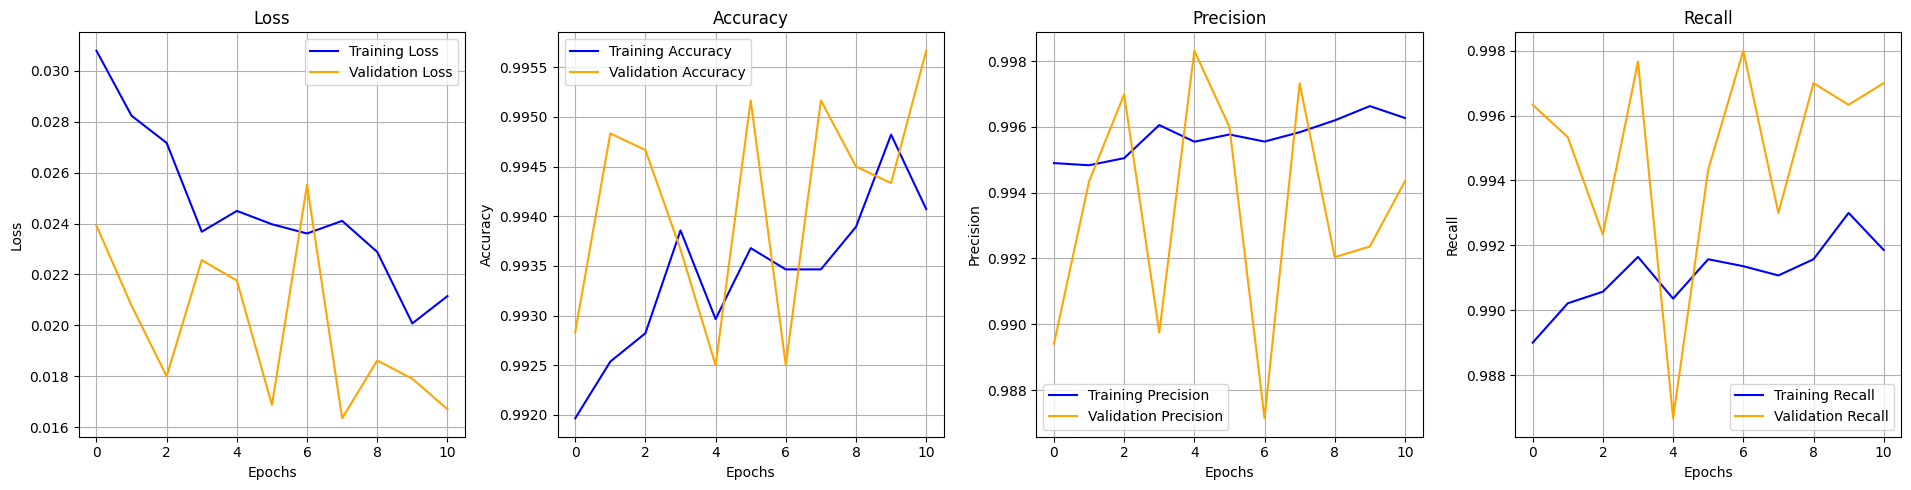

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 5))

metrics = ['loss', 'accuracy', 'precision', 'recall']
titles = ['Loss', 'Accuracy', 'Precision', 'Recall']

for i, metric in enumerate(metrics):
    plt.subplot(1, 5, i+1)  # 1 row, 5 columns now

    # Plot training metrics
    if metric in history_aug.history:
        plt.plot(history_aug.history[metric], label=f'Training {titles[i]}', color='blue')

    # Plot validation metrics
    if f'val_{metric}' in history_aug.history:
        plt.plot(history_aug.history[f'val_{metric}'], label=f'Validation {titles[i]}', color='orange')

    plt.title(titles[i])
    plt.xlabel('Epochs')
    plt.ylabel(titles[i])
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

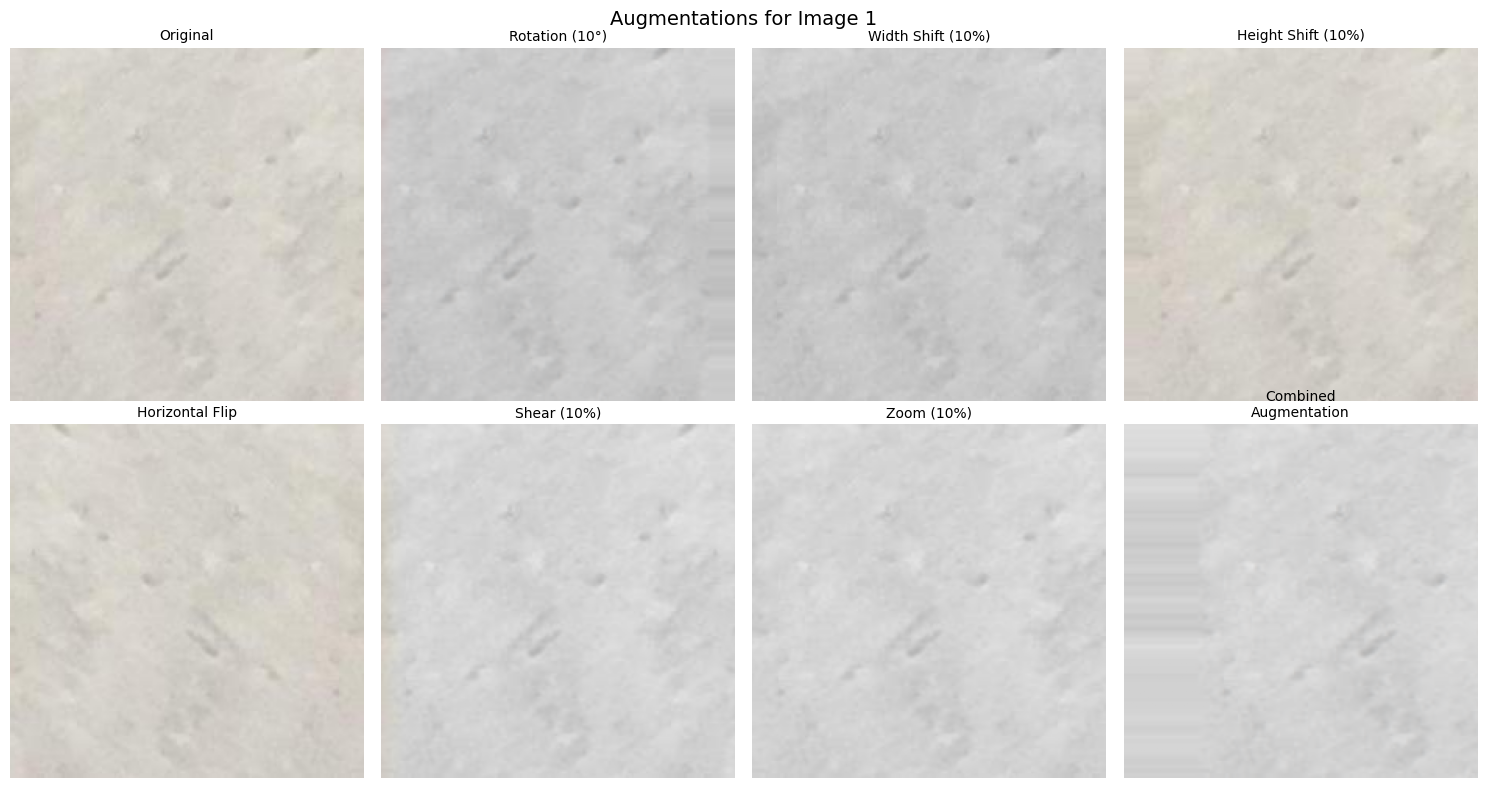

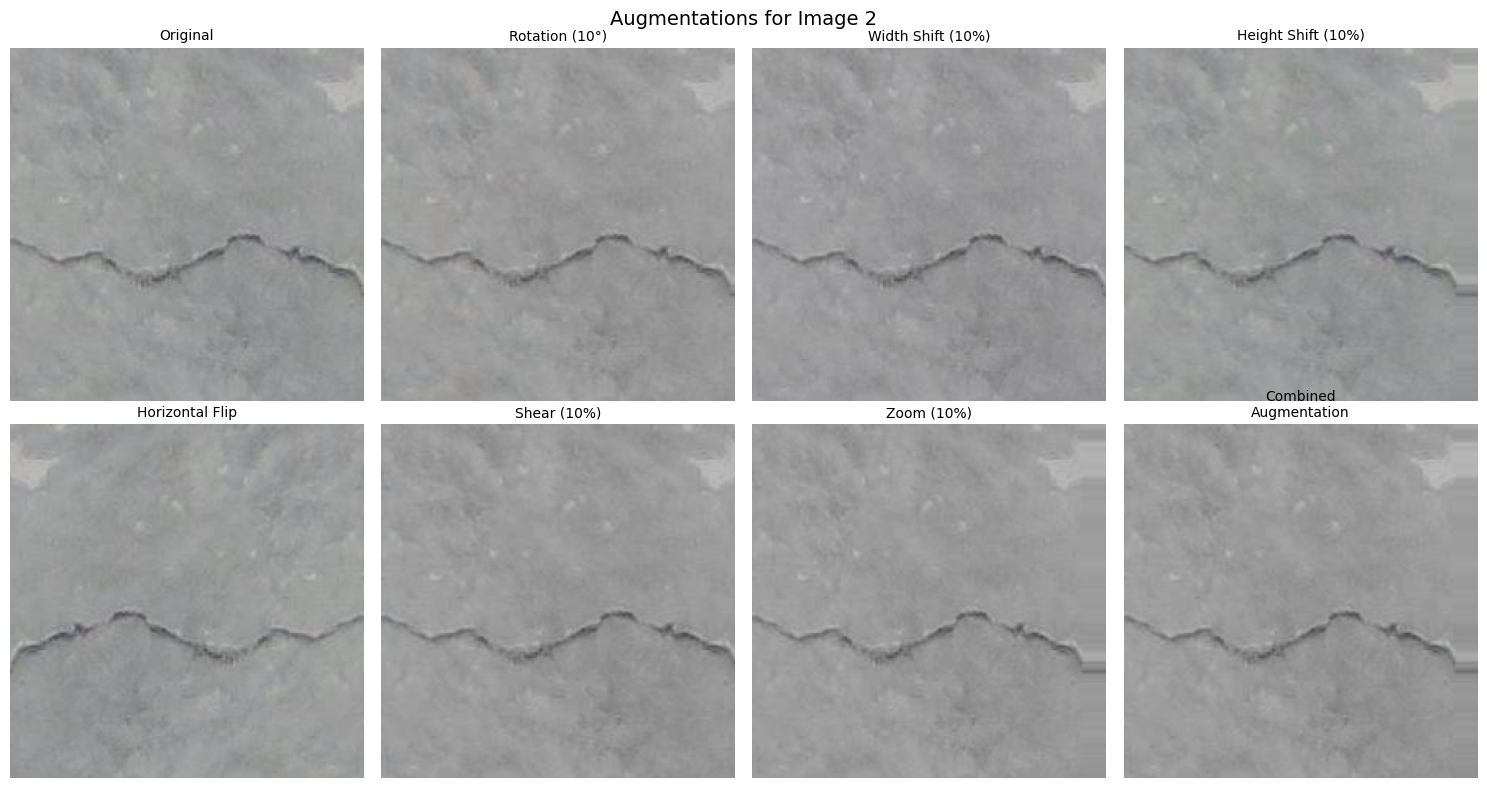

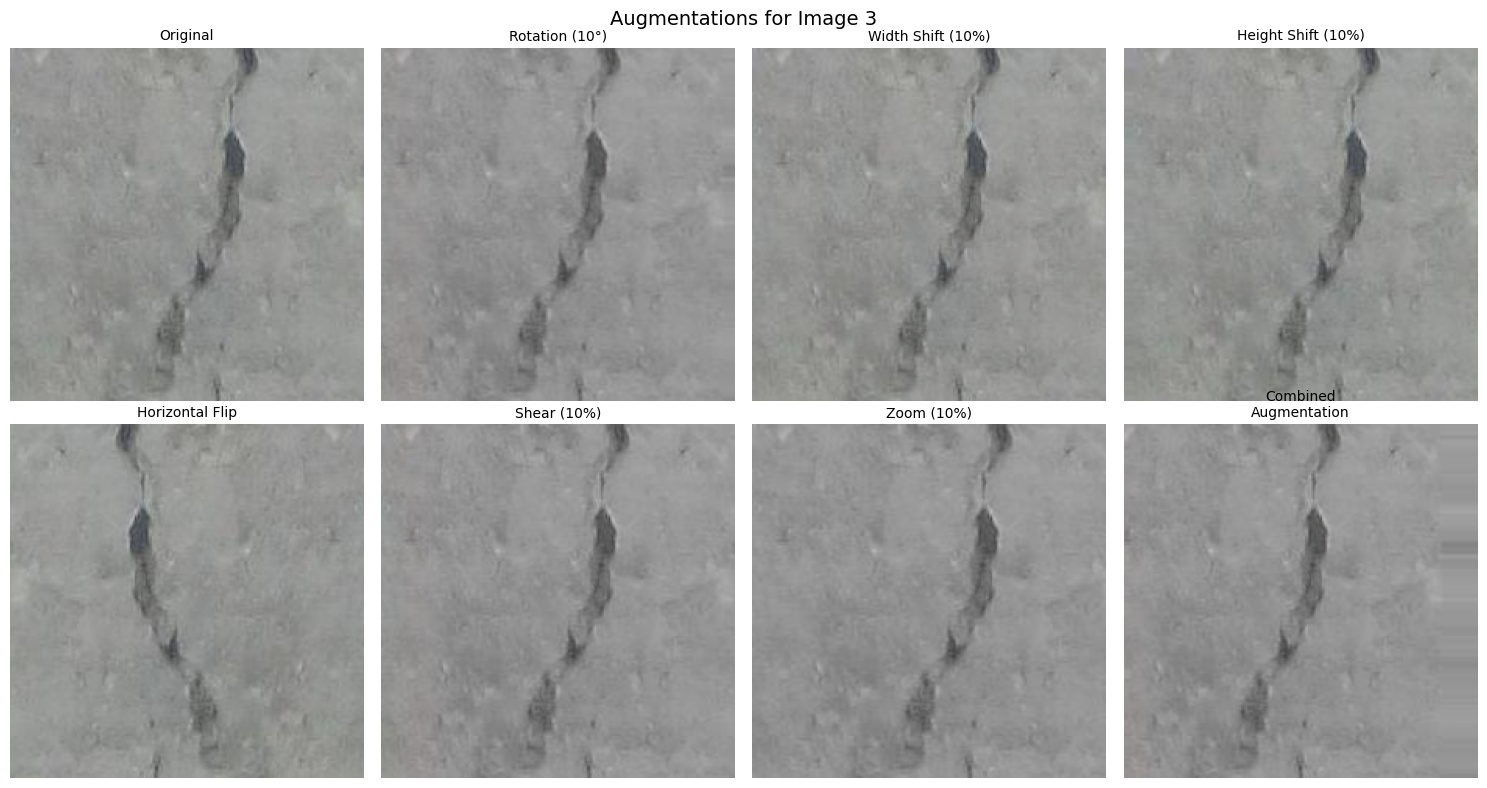

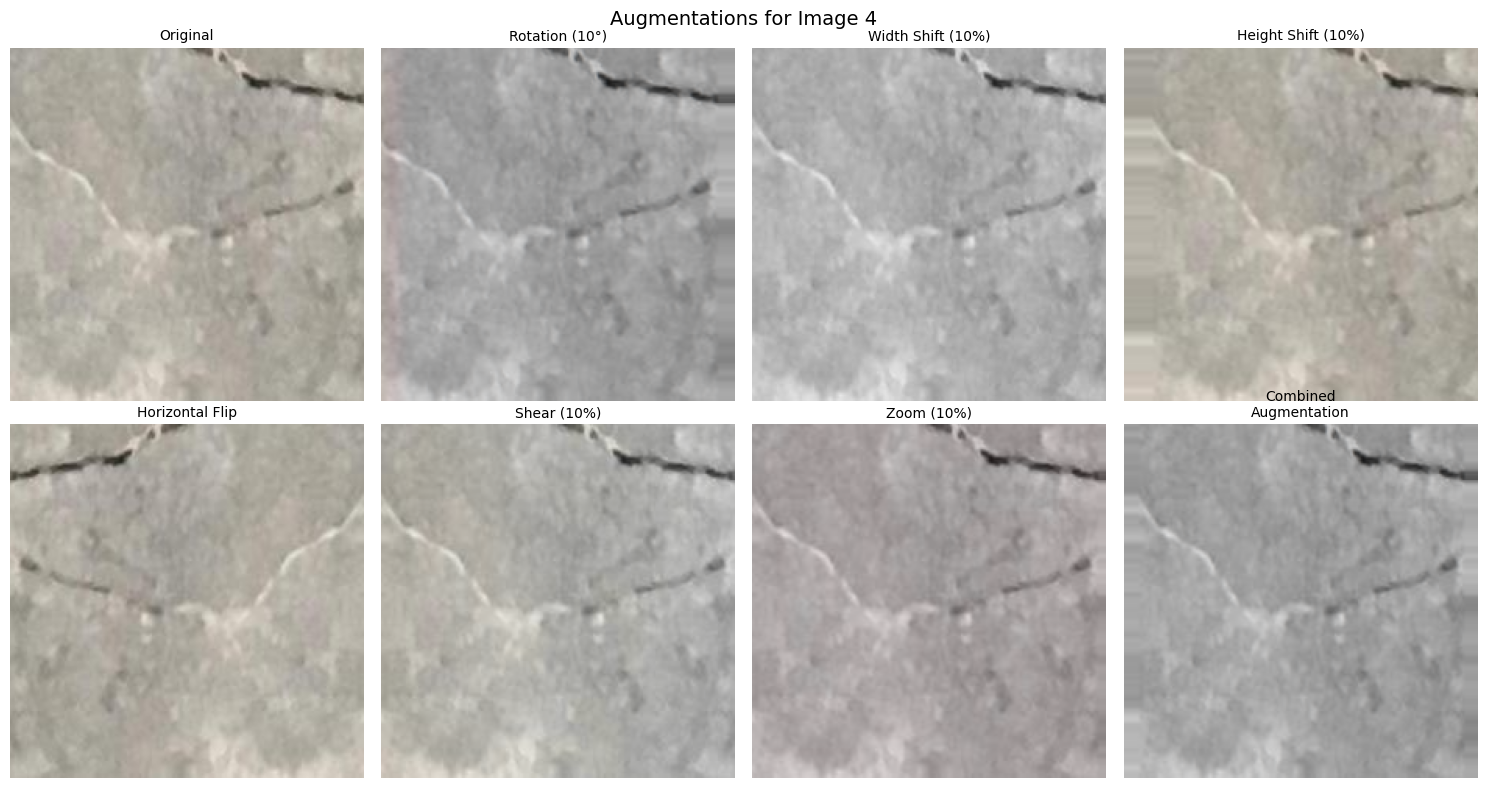

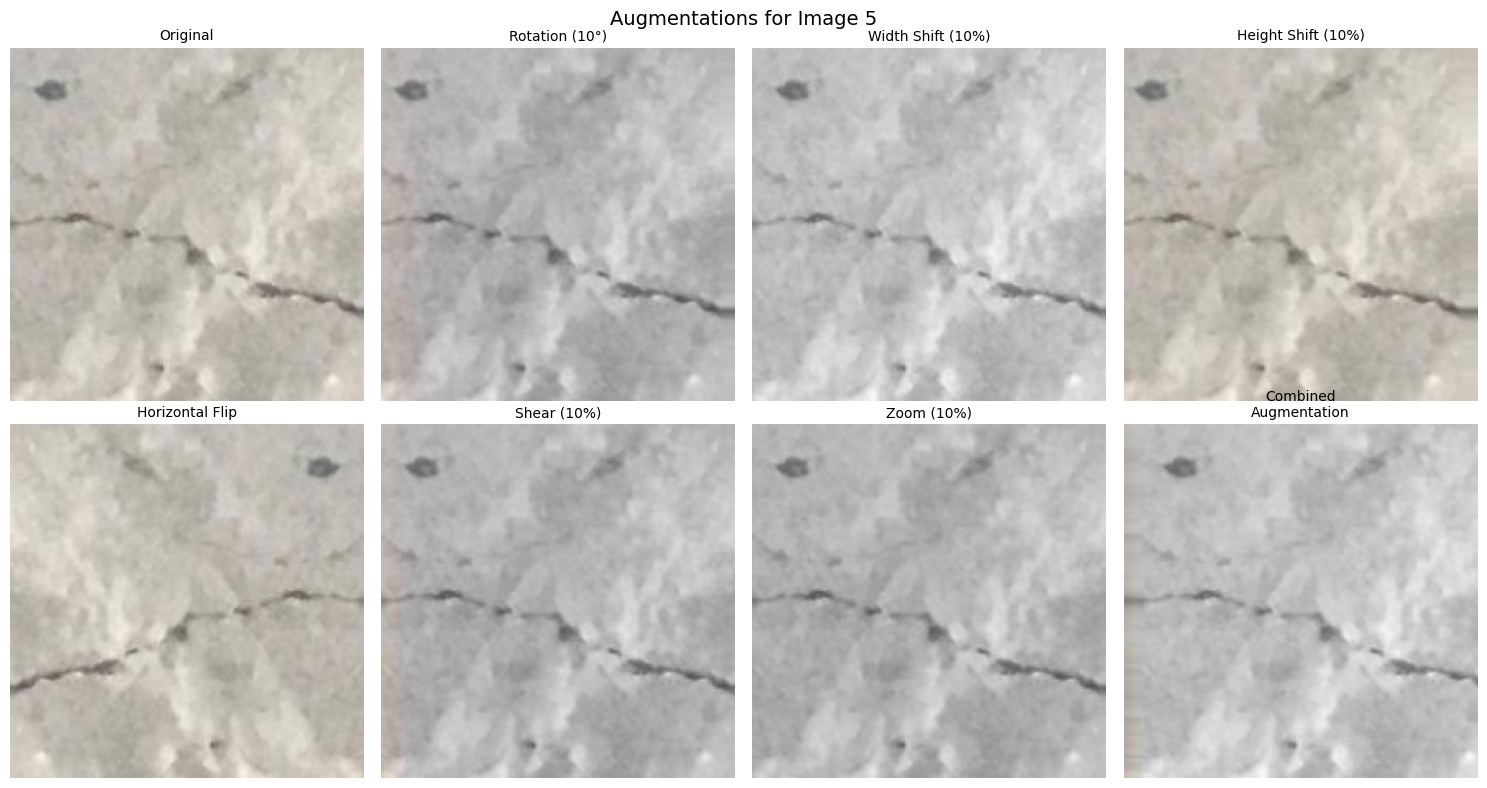

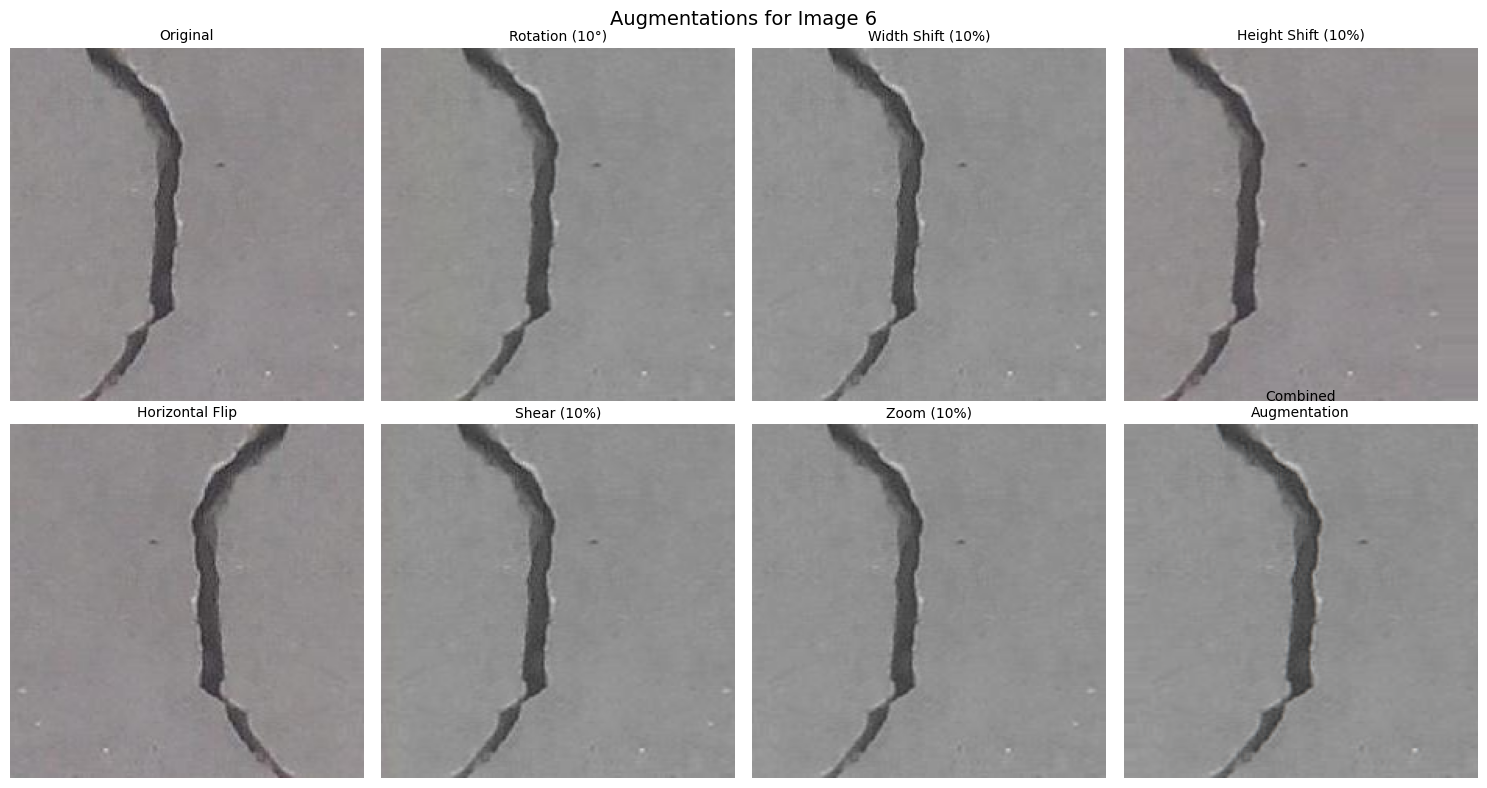

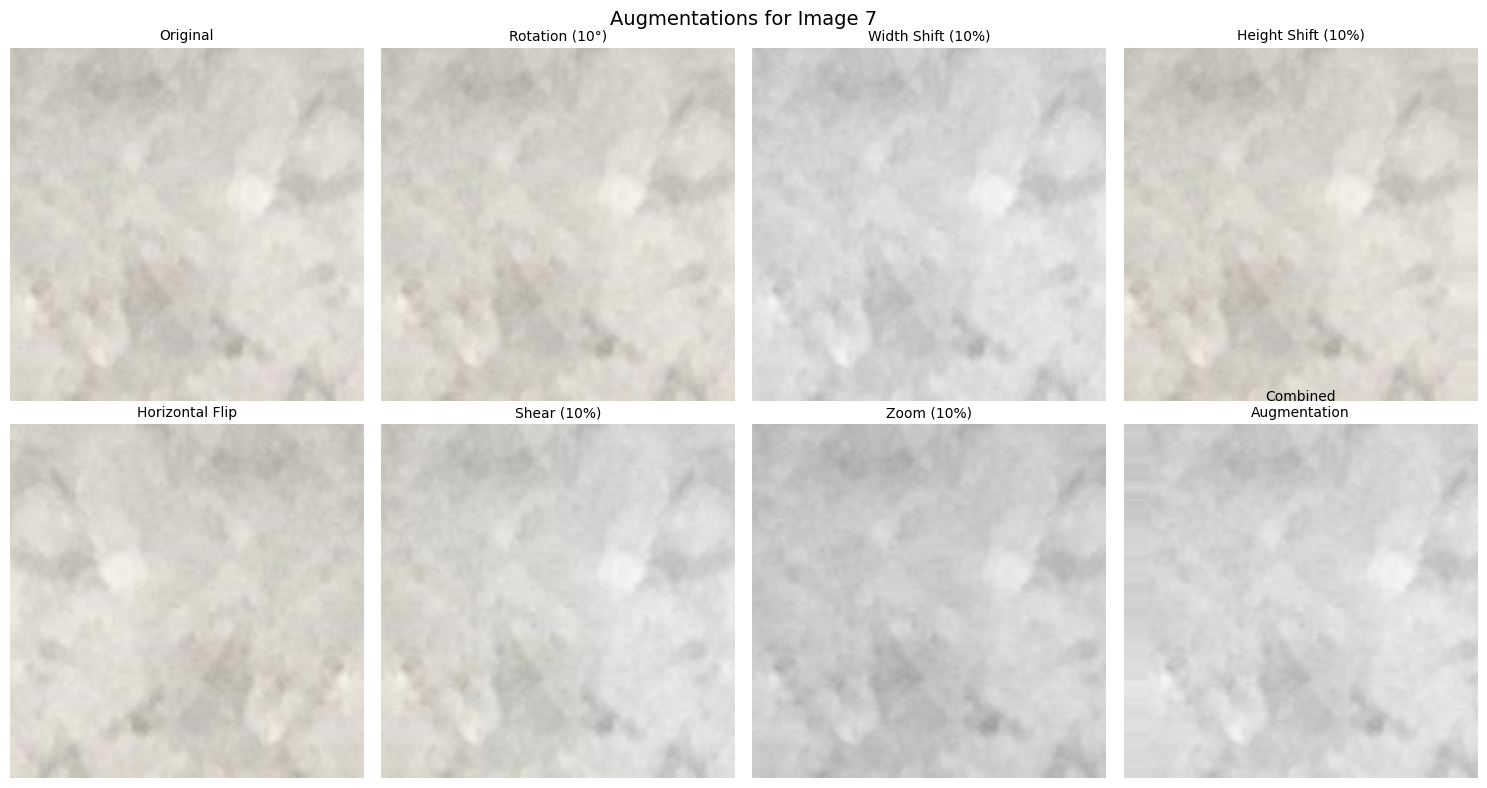

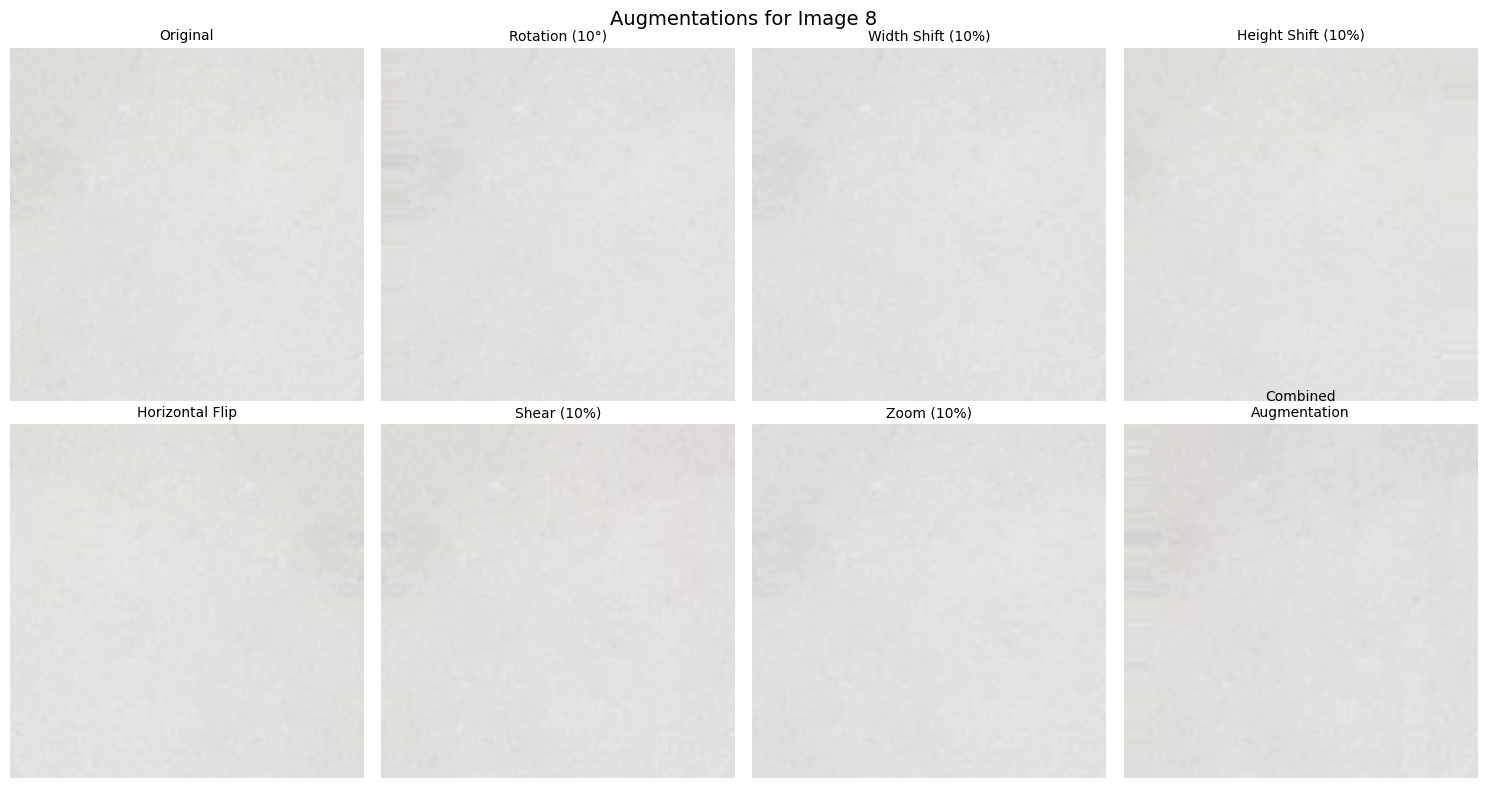

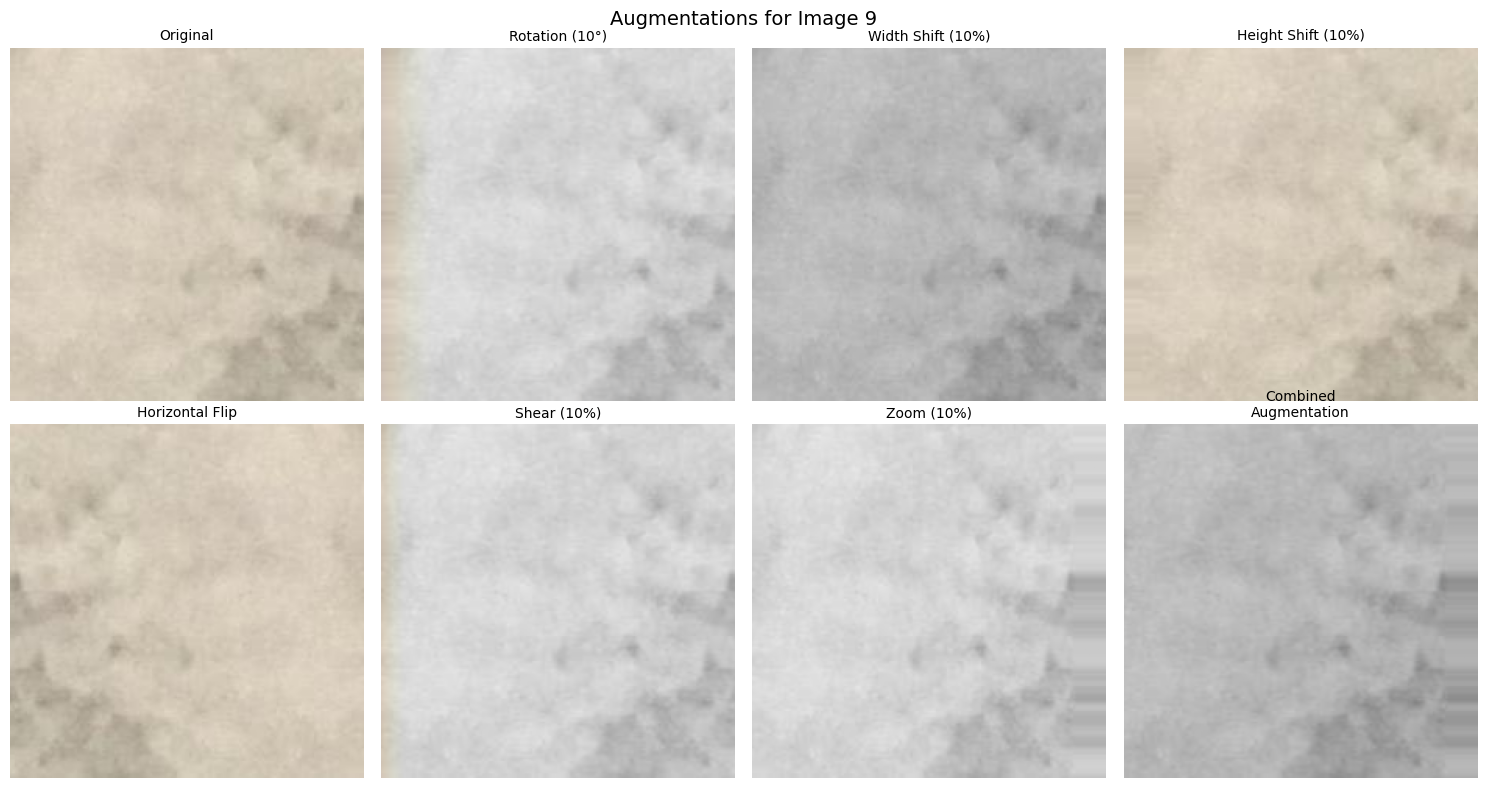

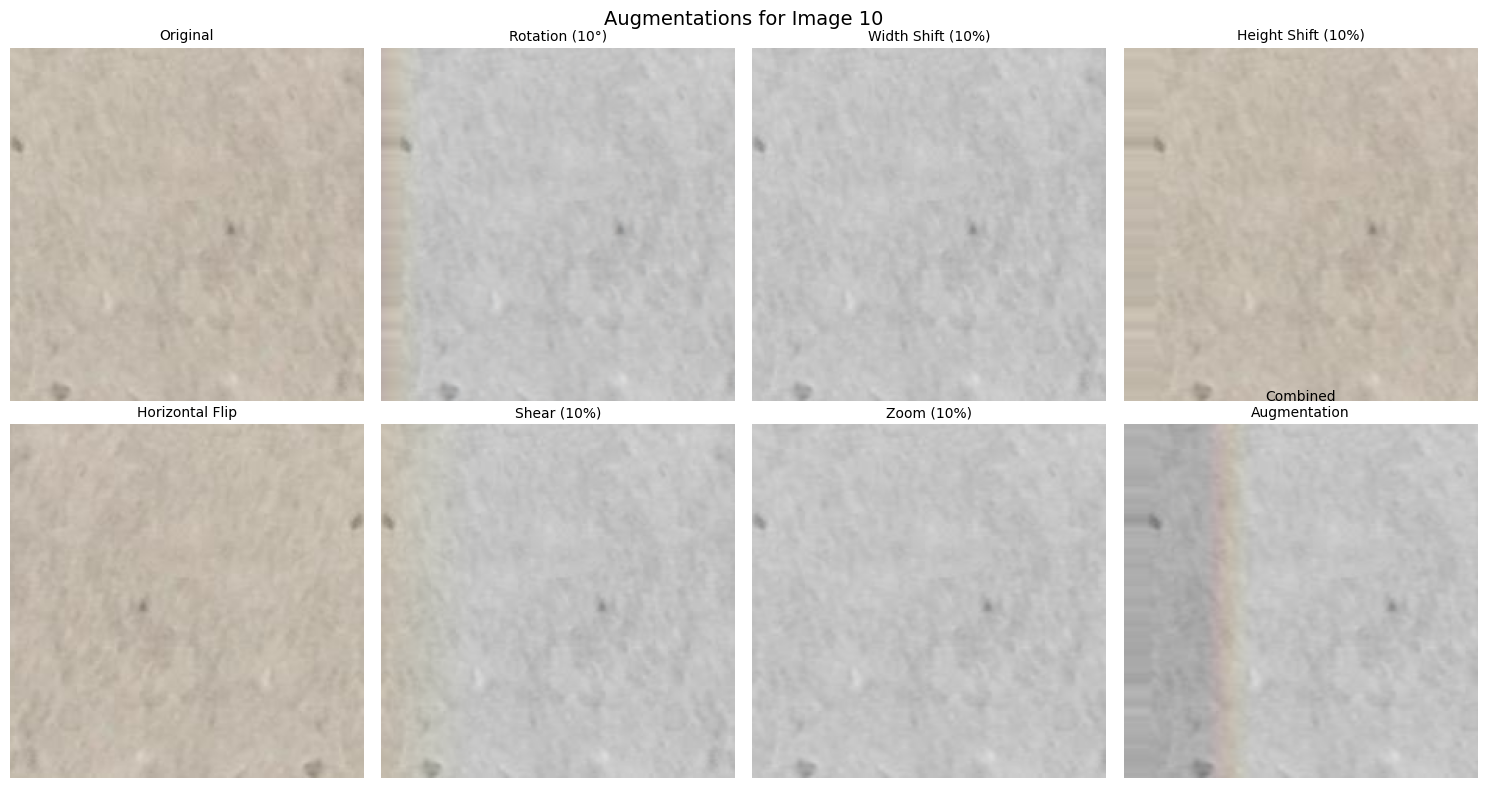

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, apply_affine_transform

# List of 10 image file paths
image_paths = [f'/content/aug{i}.jpg' for i in range(1, 11)]

# Define augmentations
augmentations = [
    {'name': 'Original', 'func': lambda x: x},
    {'name': 'Rotation (10°)', 'func': lambda x: apply_affine_transform(
        x, theta=np.random.uniform(-10, 10), fill_mode='nearest')},
    {'name': 'Width Shift (10%)', 'func': lambda x: apply_affine_transform(
        x, tx=np.random.uniform(-0.1, 0.1) * x.shape[1], fill_mode='nearest')},
    {'name': 'Height Shift (10%)', 'func': lambda x: apply_affine_transform(
        x, ty=np.random.uniform(-0.1, 0.1) * x.shape[0], fill_mode='nearest')},
    {'name': 'Horizontal Flip', 'func': lambda x: np.fliplr(x)},
    {'name': 'Shear (10%)', 'func': lambda x: apply_affine_transform(
        x, shear=np.random.uniform(-10, 10), fill_mode='nearest')},
    {'name': 'Zoom (10%)', 'func': lambda x: apply_affine_transform(
        x, zx=np.random.uniform(0.9, 1.1), zy=np.random.uniform(0.9, 1.1), fill_mode='nearest')},
    {'name': 'Combined\nAugmentation', 'func': lambda x: apply_affine_transform(
        x,
        theta=np.random.uniform(-10, 10),
        tx=np.random.uniform(-0.1, 0.1) * x.shape[1],
        ty=np.random.uniform(-0.1, 0.1) * x.shape[0],
        shear=np.random.uniform(-10, 10),
        zx=np.random.uniform(0.9, 1.1),
        zy=np.random.uniform(0.9, 1.1),
        fill_mode='nearest'
    )}
]

# Loop through all images
for idx, image_path in enumerate(image_paths):
    try:
        # Load and preprocess the image
        original_image = load_img(image_path, target_size=(227, 227))
        original_array = img_to_array(original_image) / 255.0

        # Create a new figure for each image
        plt.figure(figsize=(15, 8))
        for i, aug_config in enumerate(augmentations):
            try:
                augmented = aug_config['func'](original_array.copy())
                augmented = np.clip(augmented, 0, 1)

                plt.subplot(2, 4, i+1)
                plt.imshow(augmented)
                plt.title(aug_config['name'], fontsize=10)
                plt.axis('off')
            except Exception as e:
                print(f"Error applying {aug_config['name']} on image {image_path}: {str(e)}")

        plt.suptitle(f'Augmentations for Image {idx+1}', fontsize=14)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error loading image {image_path}: {str(e)}")


### **4.4: Visualize Model Predictions (Correct vs Incorrect)**
This section visualizes examples of model predictions on the test set, categorized as:

* **True Positives (TP):** Correctly predicted positive class.

* **True Negatives (TN):** Correctly predicted negative class.

* **False Positives (FP):** Negative images wrongly predicted as positive.

* **False Negatives (FN):** Positive images wrongly predicted as negative.

The visualization helps in error analysis and understanding model behavior.

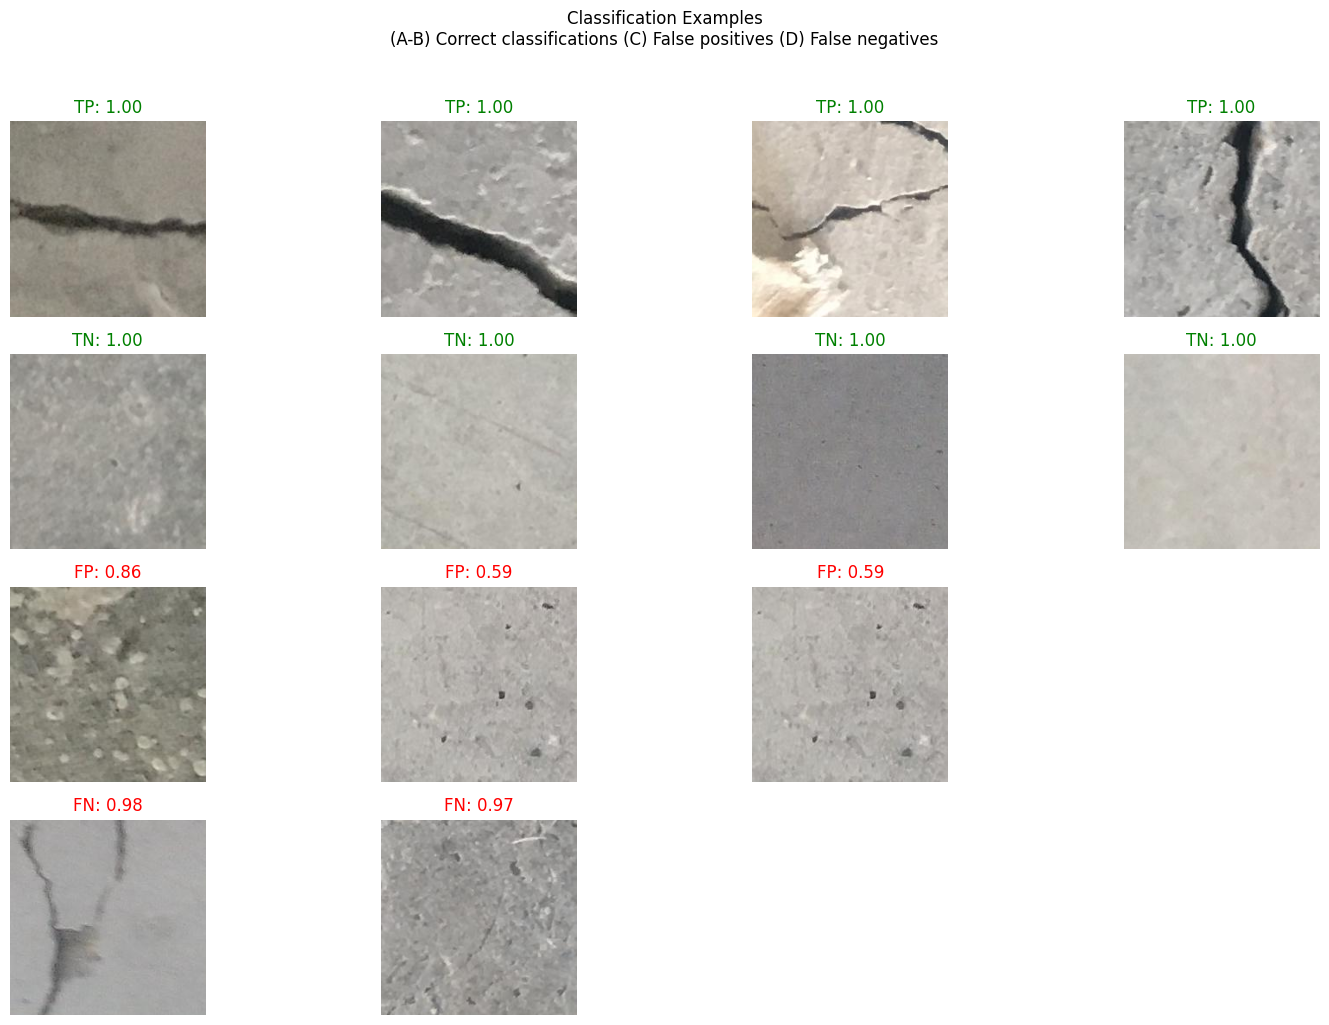

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def plot_classification_examples(model, test_dir, num_examples=4):
    # Get file paths from test directory
    test_pos = [os.path.join(test_dir, 'Positive', f) for f in os.listdir(os.path.join(test_dir, 'Positive'))]
    test_neg = [os.path.join(test_dir, 'Negative', f) for f in os.listdir(os.path.join(test_dir, 'Negative'))]

    # Initialize containers
    true_positives = []
    true_negatives = []
    false_positives = []
    false_negatives = []

    # Process Positive class
    for img_path in test_pos[:500]:  # Check first 500 to save time
        img = image.load_img(img_path, target_size=(227, 227))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0) / 255.0

        pred = model.predict(x, verbose=0)[0][0]
        if pred >= 0.5:  # Correct prediction (True Positive)
            true_positives.append((img_path, pred))
        else:  # False Negative
            false_negatives.append((img_path, pred))

    # Process Negative class
    for img_path in test_neg[:500]:
        img = image.load_img(img_path, target_size=(227, 227))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0) / 255.0

        pred = model.predict(x, verbose=0)[0][0]
        if pred < 0.5:  # Correct prediction (True Negative)
            true_negatives.append((img_path, pred))
        else:  # False Positive
            false_positives.append((img_path, pred))

    # Create visualization
    plt.figure(figsize=(15, 10))

    # Plot True Positives (A)
    for i, (img_path, pred) in enumerate(true_positives[:num_examples]):
        img = image.load_img(img_path)
        plt.subplot(4, num_examples, i+1)
        plt.imshow(img)
        plt.title(f"TP: {pred:.2f}", color='green')
        plt.axis('off')

    # Plot True Negatives (B)
    for i, (img_path, pred) in enumerate(true_negatives[:num_examples]):
        img = image.load_img(img_path)
        plt.subplot(4, num_examples, num_examples+i+1)
        plt.imshow(img)
        plt.title(f"TN: {1-pred:.2f}", color='green')
        plt.axis('off')

    # Plot False Positives (C)
    for i, (img_path, pred) in enumerate(false_positives[:num_examples]):
        img = image.load_img(img_path)
        plt.subplot(4, num_examples, 2*num_examples+i+1)
        plt.imshow(img)
        plt.title(f"FP: {pred:.2f}", color='red')
        plt.axis('off')

    # Plot False Negatives (D)
    for i, (img_path, pred) in enumerate(false_negatives[:num_examples]):
        img = image.load_img(img_path)
        plt.subplot(4, num_examples, 3*num_examples+i+1)
        plt.imshow(img)
        plt.title(f"FN: {1-pred:.2f}", color='red')
        plt.axis('off')

    plt.suptitle("Classification Examples\n(A-B) Correct classifications (C) False positives (D) False negatives", y=1.02)
    plt.tight_layout()
    plt.savefig('classification_examples.png', bbox_inches='tight')
    plt.show()

# Usage with your model
plot_classification_examples(model, test_dir=os.path.join(base_dir, "test"), num_examples=4)